# Sorted Maximum Objective

In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

# #needed
# from ipywidgets import IntProgress
# from IPython.display import display

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.
camelsgb_id = "lamah_208082"

  The start and end date of the experiment have to be specified. The start and end date of the calibration have to be specified as well. The period of calibration is chosen to be around 75% of the experiment period. This means that the model is trained on 75% of the observation data, and can be tested on 25% of the observation data, to make sure the model is not only working for the data it was trained on, but on other periods of data as well. 

In [3]:
# calibration dates op 75% van de experiment dates zetten!!!

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2007-08-31T00:00:00Z"

validation_start_time = "2007-09-01T00:00:00Z" 
validation_end_time = experiment_end_date

The forcing data can be generated or previously generated data can be loaded.

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [26]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

# print(camelsgb_forcing)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below, and is plotted.

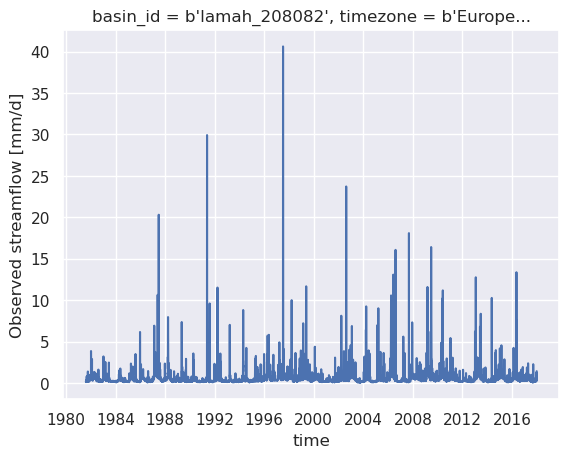

In [6]:
#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
ds_forcing["Q"].plot()

In [28]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]

In [8]:
def calibrationObjective_sorted_maximum(modelOutput, observation, start_calibration, end_calibration):
    # a function that takes in two dataFrames, sorts both the model output and the
    # observations and calculates the average absolute difference between the two.

    # filter the dataframes using the provided dates
    model_output_filtered = modelOutput.loc[start_calibration:end_calibration]
    observation_filtered = observation.loc[start_calibration:end_calibration]
    
    # Sort data from high to low
    sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
    sorted_obs_data = np.sort(observation_filtered)[::-1]
    
    #calculate return periods
    m = len(sorted_model_data)
    rank = np.arange(1, m + 1)
    return_periods_days_model = (m + 1) / rank
    return_periods_years_model = return_periods_days_model / 365.25
    
    
    m = len(sorted_obs_data)
    rank = np.arange(1, m + 1)
    return_periods_days_obs = (m + 1) / rank
    return_periods_years_obs = return_periods_days_obs / 365.25

    # 0.5 because we want to focus on the peaks, so look at discharges that occure more than 2 times a year
    return_periods_years_model_subset = return_periods_years_model[return_periods_years_model >= 0.5]
    sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0.5]
    return_periods_years_obs_subset = return_periods_years_obs[return_periods_years_obs >= 0.5]
    sorted_obs_data_subset = sorted_obs_data[return_periods_years_obs >= 0.5]

    #raise an error of the resulting datasets are not equal length. Other option: interpolate one to the other
    if len(return_periods_years_model_subset) is not len (return_periods_years_obs_subset): raise ValueError("Observation and model dataset different length")

    #calculate the differences between the model and the observations
    diff = sorted_model_data_subset - sorted_obs_data_subset
    absDiff = np.abs(diff)
    meanAbsDiff = np.mean(absDiff)
    
    return meanAbsDiff

In [9]:
Q_pandas = ds_forcing["Q"].to_dataframe()

def objective_function_sorted_maximum(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'Modelled_discharge': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective_sorted_maximum(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [10]:
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# result = minimize(objective_function_sorted_maximum, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

In [11]:
# result

In [12]:
# result.x
# 90/10
# # result = [6.51669781e-05, 6.38655600e-01, 5.30024294e+01, 1.56641841e+00,
# #        1.10734080e+00, 1.49999999e+00, 5.50209588e-01, 3.74966606e-02,
# #        1.04773070e+00]

# 70/30
# result = [5.15724216e-05, 8.36587345e-01, 3.90778393e+01, 3.57466531e+00,
#        1.06383450e+00, 9.37562028e-01, 3.02412699e-01, 8.15566365e-02,
#        2.90551458e+00]


result = [2.80513421e-03, 4.87314692e+03, 1.42510373e+05, 1.45785523e+00,
       4.44291807e+03, 7.15000000e+01, 1.00000000e-03, 1.57140581e-01,
       1.83708672e-02]

In [13]:
# result.fun
# 90/10
# # objective = 0.027397519552779696

# 70/30
# objective = 0.01965939310646257


objective = 7.563021968360874

In [14]:
par = result
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)

In [15]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [16]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

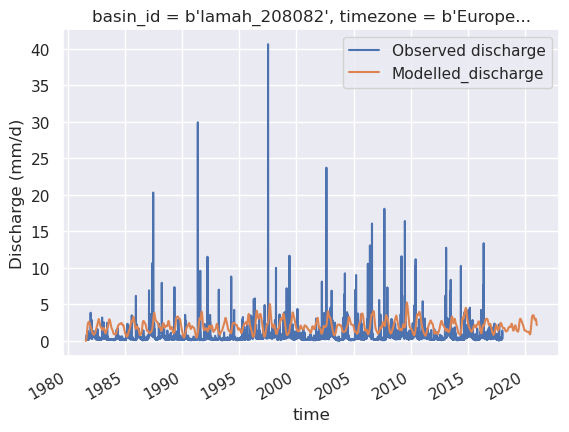

In [17]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

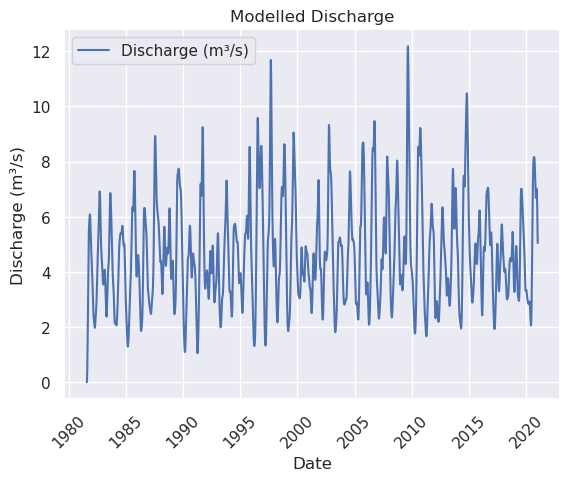

In [18]:
catchment_area = ds_forcing["area"].values

df = pd.DataFrame(model_output)
model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Modelled Discharge')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)
plt.show()

In [19]:
calibration_start_time = pd.to_datetime(calibration_start_time)
calibration_end_time = pd.to_datetime(calibration_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
calibration_start_time = calibration_start_time.tz_localize(None)
calibration_end_time = calibration_end_time.tz_localize(None)

model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
ds_forcing_filtered = ds_forcing["Q"].loc[calibration_start_time:calibration_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

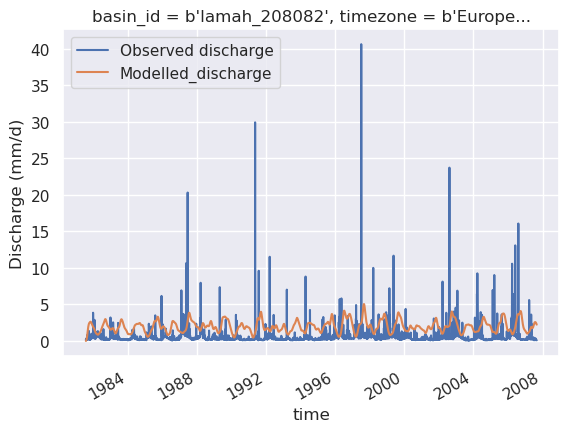

In [20]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

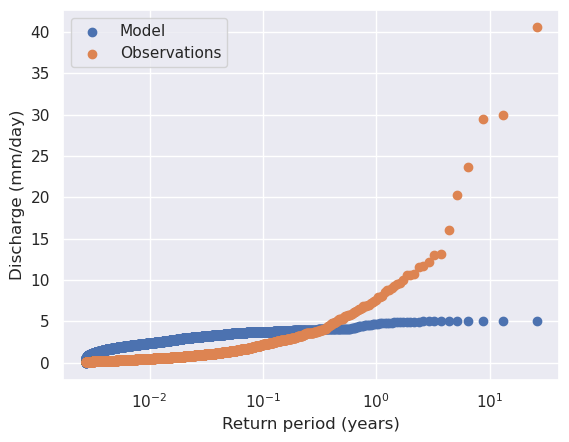

In [21]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

In [22]:
validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)
# Filter de modeloutput voor de geselecteerde periode
model_output_filtered = model_output.loc[validation_start_time:validation_end_time]

# Als je ook de waargenomen afvoer wilt filteren, doe je hetzelfde:
ds_forcing_filtered = ds_forcing["Q"].loc[validation_start_time:validation_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

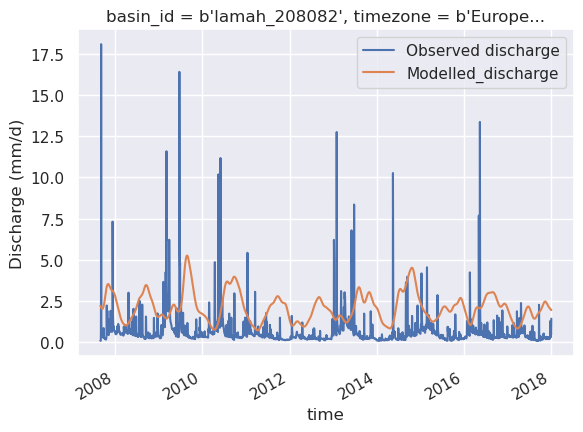

In [23]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

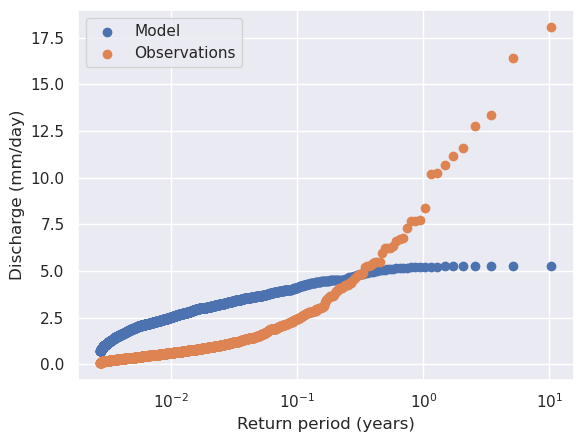

In [24]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below.

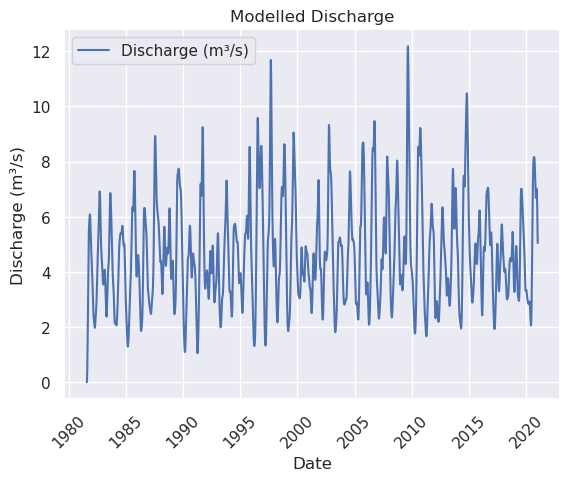

In [25]:
catchment_area = ds_forcing["area"].values

df = pd.DataFrame(model_output)
model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Modelled Discharge')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

# plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)
plt.show()